# MediaCloud API Python interface for ReThink Media's 9/11 report
Functions for ReThink's analysis of media coverage surrounding the 20th anniversary of 9/11 will be developed within this notebook.

In [1]:
# importing dependencies for MediaCloud API
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import mediacloud.api
from dateutil import parser
import time
import matplotlib.pyplot as plt

# loading config from .env file
load_dotenv()

True

In [20]:
# reading API key from .env
mc_api_key = os.getenv("MC_API_KEY")

# instantiating MediaCloud API
mc = mediacloud.api.MediaCloud(mc_api_key)
mediacloud.__version__

'3.12.4'

In [ ]:
# verifying API connection by printing some high-level stats
mc.stats()

## Defining sources and search strings
These source dicts and search strings will be used in analysis, and passed into the functions below.

In [1]:
# defining sources and ID's in MediaCloud API
# commented sources cannot be found in MediaCloud's Source Manager
sources = {
    "Washington Post": 2,
    "New York Times": 1,
    "USA Today": 4,
    "LA Times": 6,
    "Bloomberg": 40944,
    "Christian Science Monitor": 3,
    "New York Daily News": 8,
    "Star Ledger (NJ)": 16,
    "The Philadelphia Inquirer (PA)": 18,
    "The Pittsburgh Post-Gazette (PA)": 45,
    "PennLive/Patriot-News (PA)": 662863,
    "The Day (CT)": 76581,
    "Hartford Courant (CT)": 59,
    "Baltimore Sun (MD)": 34,
    "The Capital Gazette (MD)": 70310,
    "The Virginian-Pilot (VA)": 55,
    "The Richmond Times-Dispatch (VA)": 53,
    "Boston Globe (MA)": 15,
    "Portland Press Herald (ME)": 366984,
    "Houston Chronicle (TX)": 10,
    "Austin American Statesman (TX)": 62,
    "Atlanta Journal Constitution (GA)": 22916,
    "Raleigh News and Observer (NC)": 58,
    "The Cleveland Plain Dealer (OH)": 662541
}

novetta_sources = {
    "Associated Press": 1154,
    "Black Agenda Report": 26040,
    "Bustle": 98755,
    "News One": 24661,
    "NPR": 1096,
    "PBS NewsHour": 271188,
    "Politico": 18268,
    "The Root": 368082,
    "Vice": 26164,
    "Al Monitor": 102745,
    "Al Jazeera English": 1148,
    "Buzzfeed": 6218,
    "Chicago Tribune": 9,
    "CNN Wire": 1095,
    "Fox News": 1092,
    "Houston Chronicle": 10,
    "HuffPost": 27502,
    "LA Times": 6,
    "Mic": 109076,
    "Middle East Eye": 107733,
    "Middle East Monitor": 97329,
    "Newsweek": 56510,
    "Reuters News": 4442,
    "Roll Call": 19854,
    "Slate": 4425,
    "Talking Points Memo": 113,
    "The Arizona Republic": 158115,
    "The Atlanta Journal Constitution": 22916,
    "The Atlantic": 1110,
    "The Boston Globe": 15,
    "Christian Science Monitor": 3,
    "The Daily Beast": 1707,
    "The Express Tribune (Pakistan)": 25888,
    "The Hill": 18364,
    "The Intercept": 269138,
    "The Miami Herald": 28,
    "New York Times": 1,
    "The Wall Street Journal": 1150,
    "The Washington Post": 2,
    "The Washington Times": 101,
    "US News and World Report": 1100,
    "USA Today": 4,
    "Vox": 104828,
    "Defense News": 39177,
    "Defense One": 69881,
    "War is Boring": 97642,
    "War on the Rocks": 72738
}

In [2]:
# defining search strings. Search strings must be enclosed by parentheses for MediaCloud API to properly search.
# general 9/11 search string
sep11_search = '("9/11" OR "September 11th" OR "September 11" OR \
(("terrorist attack" OR "terrorist attacks" OR "Al Qaeda") AND "New York") OR \
"twin towers" OR "world trade center" OR "bin laden" OR "ground zero" OR "WTC")'

# endless war/drone killings/etc search string
endless_war_search = '("endless war" OR "forever war" OR "perpetual war" OR \
"foreign policy" OR "war on terror” OR "Pentagon budget" OR \
(("Military budget" OR "military spending" OR "defense budget" OR "defense spending") AND \
("United States" OR American OR Pentagon OR America OR "U.S.")) OR \
"war powers" OR "AUMF" OR "Authorization for use of military force" OR \
((drone OR drones OR "unmanned aerial vehicle" OR "unmanned aerial vehicles") AND \
(terror OR terrorist OR terrorists OR ISIS OR ISIL OR "Islamic State" OR armed OR \
weaponize OR weaponized OR weaponise OR weaponised OR attack OR technology OR \
Afghanistan OR "civilian casualty" OR "civilian casualties")) OR \
"targeted killing" OR "targeted killings")'

# racial/religious profiling search string
# cut out 'End Radical Profiling Act' OR ERPA
profiling_search = '''(((muslim OR islam* OR arab OR (south AND asia*) OR mosque OR imam OR sikh) AND \
(profil* OR discriminat* OR "no fly list" OR "no-fly list" OR islamophobia OR FBI OR radical* OR terror* \
OR jihad* OR homegrown OR "home grown" OR "home-grown")) OR ("End Radical Profiling Act" OR ERPA) OR \
((homegrown OR "home grown" OR "home-grown") AND (terror* OR radical*)) OR (sharia OR shariah OR sha'ariah \
OR sh'ariah OR shari'ah OR shari'a) OR "muslim ban")'''

## Utility functions
Functions that set up MediaCloud API calls, formatting inputs, etc., for general use in the rest of the functions.

In [3]:
# defining API key, instantiating MediaCloud API
def init_mc_api(api_key=None):
    
    # importing necessary modules
    from dotenv import load_dotenv
    import os
    import mediacloud.api
    
    # loading environment variables from .env file
    load_dotenv()
    
    # if no API key is passed, function assumes API key is defined in .env file as MC_API_KEY
    if not api_key:
        api_key = os.getenv("MC_API_KEY")
    
    # returning API instance
    return mediacloud.api.MediaCloud(api_key)

In [4]:
# formatting date ranges for MediaCloud API calls.
# required arguments: MediaCloud API instance (from init_mc_api) and date range, eg ["8/1/2021", "9/30/2021"]
def clean_api_date(mediacloud_api, date_range, verbose=False):
    
    # importing necessary modules
    from datetime import datetime
    from dateutil import parser
    
    # making sure two dates are passed into the function
    assert len(date_range) == 2, "Please provide both a start and end date for the date interval."
    
    # parsing dates, returning API date range clause
    start_date = parser.parse(date_range[0])
    end_date = parser.parse(date_range[1])
    if verbose:
        print(f"Date range: between {start_date.strftime('%m/%d/%Y')} and {end_date.strftime('%m/%d/%Y')}")
    return mediacloud_api.dates_as_query_clause(start_date, end_date)

In [5]:
# ensuring that the sources passed into functions are of the correct format
# dict, with format {source_name: MediaCloud_ID}
# setting relevant query parameter for individual source vs MediaCloud collection search
def check_source_type(sources, source_type):
    assert type(sources) == dict,\
    "Please provide the sources in a dict, in the format <Source Name>: <MediaCloud ID>"
    
    assert source_type in {"media", "collection"},\
    'Please specify either "media" or "collection" as source_type.'
    
    if source_type == "media":
        mc_source_type = "media_id"
    elif source_type == "collection":
        mc_source_type = "tags_id_media"
    return mc_source_type

## Story count for multiple sources:
Defining a function to count the number of stories about a topic that is passed into the function. Pass a query and a dictionary of source names and MediaCloud media ID's into the function, and it will return a pandas DataFrame with each source's relevant stories, total stories, and attention to the passed query, measured by percent coverage. You can also pass a range of dates into the function to make your search more specific.

The arguments for the function are:
- `query`: The query that you would like to find relevant stories for
- `sources`: A dict of news sources to search, formatted as {`source name`: `MediaCloud ID`}
- `source_type`: "media" or "collection". MediaCloud has different query tags for searching individual sources versus searching source collections, and this parameter specifies which one you would like to use.
- `date_range`: \[`start_date`, `end_date`] for the query
- `query_context`: The overall context that you would like to search within. `query_context=None` will set the context to all of the source's stories within `date_range`, or you can pass a query to calculate attention within a more specific context.
- `api_key`: MediaCloud API key. `api_key=None` assumes that the API key is defined in a `.env` file as `MC_API_KEY`.
- `verbose`: Whether or not to print information as the function runs.
- `urls`: If `True`, the function will add a column to the DataFrame with 20 sample stories from each source relevant to the query.

In [6]:
# building a function to search a string among the sources given
def search_sources(query, sources, source_type="media", date_range=None,
                   query_context=None, api_key=None, verbose=False, urls=False):
    
    # initializing MediaCloud API, checking source format, cleaning date_range
    mc = init_mc_api(api_key=api_key)
    mc_source_type = check_source_type(sources, source_type)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # ensuring the query is a string
    query = str(query)
    print(f"Query: {query}")
    
    # initializing dataframe to store the query data
    import pandas as pd
    import numpy as np
    if urls:
        story_counts = pd.DataFrame(columns=["Name", "Relevant Stories", "Total Stories", "Attention (%)", "Story URLs"])
    else:
        story_counts = pd.DataFrame(columns=["Name", "Relevant Stories", "Total Stories", "Attention (%)"])
    story_counts.index.name = "MediaCloud ID"
    
    # going through each source and querying relevant and total stories
    for source_name in sources:
        if verbose:
            print(f"{source_name}:")
        
        # defining overall context and specific query for stories
        if query_context:
            total_query = f'({query_context}) and {mc_source_type}:{sources[source_name]}'
        else:
            total_query = f'{mc_source_type}:{sources[source_name]}'
        api_query = f'({query}) and {total_query}'

        # API calls to count relevant and total stories
        relevant_stories = mc.storyCount(api_query, api_date_range)['count']
        total_stories = mc.storyCount(total_query, api_date_range)['count']
        
        # getting urls for a sample of 20 stories relevant to the query
        if urls:
            stories = mc.storyList(api_query, api_date_range, sort=mc.SORT_RANDOM)
            story_urls = [story['url'] for story in stories]
        
        # appending data to dataframe
        try:
            attention = (relevant_stories / total_stories) * 100
        except ZeroDivisionError:
            attention = np.nan
        if urls:
            story_counts.loc[sources[source_name]] = [source_name, relevant_stories, total_stories, attention, story_urls]
        else:
            story_counts.loc[sources[source_name]] = [source_name, relevant_stories, total_stories, attention]
        
        # printing story count and attention
        if verbose:
            print(f"{relevant_stories} stories about {query}, {total_stories} total")
            if not np.isnan(attention):
                print(f"{attention}% of stories are about {query}\n")
            else:
                print("")
    
    return story_counts

In [58]:
# defining query
# query = sep11_search
query = endless_war_search
# query = profiling_search
# query = f'''{sep11_search} AND ("war on terror" OR terroris* OR (islamism OR islamist) OR jihad* OR \
# (sharia OR shariah OR sha'ariah OR sh'ariah OR shari'ah OR shari'a))'''

# running and timing function
import time
start_time = time.time()
df = search_sources(query, novetta_sources, date_range=["8/1/2021", "9/30/2021"],
                    query_context=sep11_search, urls=False)
end_time = time.time()
print(f"Time: {round(end_time-start_time, 2)} s")

# filtering out sources with less than 20 total stories, sorting by decreasing attention
filtered_df = df.loc[df["Total Stories"] > 20]
filtered_df = filtered_df.sort_values(by="Attention (%)", ascending=False)

Query: ("endless war" OR "forever war" OR "perpetual war" OR "foreign policy" OR "war on terror” OR "Pentagon budget" OR (("Military budget" OR "military spending" OR "defense budget" OR "defense spending") AND ("United States" OR American OR Pentagon OR America OR "U.S.")) OR "war powers" OR "AUMF" OR "Authorization for use of military force" OR ((drone OR drones OR "unmanned aerial vehicle" OR "unmanned aerial vehicles") AND (terror OR terrorist OR terrorists OR ISIS OR ISIL OR "Islamic State" OR armed OR weaponize OR weaponized OR weaponise OR weaponised OR attack OR technology OR Afghanistan OR "civilian casualty" OR "civilian casualties")) OR "targeted killing" OR "targeted killings")
Time: 231.43 s


In [59]:
# dropping The Express Tribune (Pakistan) due to low story count
# filtered_df = filtered_df.drop(index=25888)

# displaying top 20 rows for report, rounding off percentages
filtered_df.round(decimals=1).head(n=20)

,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
269138,The Intercept,26,40,65.0
69881,Defense One,19,34,55.9
1110,The Atlantic,22,47,46.8
97329,Middle East Monitor,13,29,44.8
18268,Politico,62,140,44.3
1148,Al Jazeera English,38,108,35.2
1707,The Daily Beast,32,99,32.3
3,Christian Science Monitor,10,32,31.2
104828,Vox,8,27,29.6


In [38]:
filtered_df.to_csv("sep11_terms_attention.csv")

## Percentage of stories that mention keywords

A function to calculate the percentage of stories in all sources that mention keywords and phrases of interest. The arguments for this function are:
- `keywords`: A list of keywords or phrases to search for.
- `sources`: A dict of news sources to search, formatted as {`source name`: `MediaCloud ID`}
- `source_type`: "media" or "collection". MediaCloud has different query tags for searching individual sources versus searching source collections, and this parameter specifies which one you would like to use.
- `date_range`: \[`start_date`, `end_date`] for the query
- `query_context`: The overall context that you would like to search within. `query_context=None` will set the context to all of the source's stories within `date_range`, or you can pass a query to calculate attention within a more specific context.
- `api_key`: MediaCloud API key. `api_key=None` assumes that the API key is defined in a `.env` file as `MC_API_KEY`.

The function prints the percentage of stories containing each keyword, as well as the percentage of stories that mention any of the keywords, and returns an array of the percentages mentioned.

In [7]:
# calculating number of 9/11 stories that mention some topics and keywords we're interested in
def calculate_percentages(keywords, sources, source_type="media",
                          date_range=None, query_context=None, api_key=None):
    
    # initializing MediaCloud API, checking source format, cleaning date_range
    mc = init_mc_api(api_key=api_key)
    mc_source_type = check_source_type(sources, source_type)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # formatting media_ids for API query
    media_ids = list(sources.values())
    api_media_ids = " OR ".join(f"{mc_source_type}:{media_id}" for media_id in media_ids)

    # defining overall context and specific query for stories
    if query_context:
        total_query = f'({query_context}) and ({api_media_ids})'
    else:
        total_query = f'({api_media_ids})'
    
    # joining keywords to calculate aggregate percentages
    all_keywords = " OR ".join(keywords)

    # adding queries to list to loop through later
    keyword_queries = [f'({keyword}) and {total_query}' for keyword in keywords+[f"({all_keywords})"]]
    
    # story count for query context
    total_results = mc.storyCount(total_query, api_date_range)['count']

    # keyword story counts
    keyword_results = [mc.storyCount(keyword_query, api_date_range)['count'] for keyword_query in keyword_queries]
    
    # calculating percentages of 9/11 stories that mentioned endless war, profiling, and afghanistan
    import numpy as np
    keyword_percentages = np.divide(keyword_results, total_results) * 100
    keyword_percentages = np.around(keyword_percentages, decimals=2)
    
    # printing percentages
    print("Percentage of stories within specified context that mention:\n")
    for i in range(len(keywords)):
        print(f"{keywords[i]}: {keyword_percentages[i]}%\n")
    print(f"All Keywords: {keyword_percentages[-1]}%")
    
    return keyword_percentages

In [61]:
# testing output of calculate_percentages()
keywords = ['"war on terror"', "terroris*", "islamis*", "jihad*", 
            "(sharia OR shariah OR sha'ariah OR sh'ariah OR shari'ah OR shari'a)"]
topics = [endless_war_search, profiling_search, "afghanistan"]
date_range = ["8/1/2021", "9/30/2021"]

calculate_percentages(keywords, novetta_sources, date_range=date_range, query_context=sep11_search)

Percentage of stories within specified context that mention:

"war on terror": 7.18%

terroris*: 44.1%

islamis*: 4.6%

jihad*: 6.02%

(sharia OR shariah OR sha'ariah OR sh'ariah OR shari'ah OR shari'a): 2.13%

All Keywords: 48.17%


array([ 7.18, 44.1 ,  4.6 ,  6.02,  2.13, 48.17])

## Word clouds
This function takes a query and produces a word cloud, a visualization of the most popular words within stories relevant to the query.

In [10]:
# adapting simple_word_cloud() function from Laura's previous code
def word_cloud(query, sources, date_range, source_type="media", 
               save_img=False, filename=None, custom_stopwords=None, api_key=None, verbose=False):
    
    # initializing MediaCloud API, checking source format, cleaning date_range
    mc = init_mc_api(api_key=api_key)
    mc_source_type = check_source_type(sources, source_type)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # formatting query, sources, and date_range for API
    assert type(query) == str, "Please input a string as the query."
    media_ids = list(sources.values())
    api_media_ids = " OR ".join([f"{mc_source_type}:{media_id}" for media_id in media_ids])
    
    api_query = f"({query}) and ({api_media_ids})"
    if verbose:
        print(f"Query: {api_query}")

    # building term/document matrix, separating word list from word matrix
    story_count = mc.storyCount(api_query, api_date_range)["count"]
    doc_term_matrix = mc.storyWordMatrix(api_query, api_date_range, rows=story_count, max_words=100)
    word_list = doc_term_matrix["word_list"]
    word_matrix = doc_term_matrix["word_matrix"]
    top_words = [word[1] for word in word_list]
    
    # aggregating word frequencies in each document
    word_freqs = {}
    for word_id in range(len(top_words)):
        word_freqs[word_id] = 0
        for story in word_matrix:
            if str(word_id) in word_matrix[story]:
                word_freqs[word_id] += word_matrix[story][str(word_id)]
            else:
                continue
        word_freqs[top_words[word_id]] = word_freqs.pop(word_id)
    
    # importing modules for wordcloud
    from wordcloud import WordCloud, STOPWORDS
    import re
    import matplotlib.pyplot as plt
    
    # adding query and query_context to stopwords for wordcloud, so they don't show up and dominate the cloud
    stopwords = set(STOPWORDS)
    pattern = re.compile('[\W_]+')
    query_split = query.lower().split()
    query_stops = {pattern.sub('', word) for word in query_split}
    stopwords.update(query_stops)
    if custom_stopwords:
        stopwords.update(custom_stopwords)
    for stopword in stopwords:
        if stopword in word_freqs:
            del word_freqs[stopword]
    wc_fig = plt.figure()
    word_cloud = WordCloud(background_color="white", width=3000, height=2000,
                           stopwords=stopwords, max_words=75, prefer_horizontal=1.0)
    word_cloud.fit_words(word_freqs)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    if save_img:
        if filename:
            word_cloud.to_file(filename)
        else:
            word_cloud.to_file("wordcloud.png")
    return wc_fig

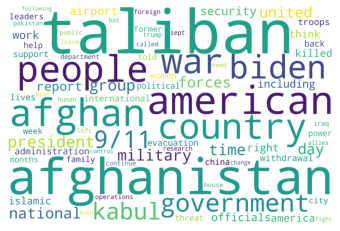

Time to run: 43.77 s


In [11]:
# testing wordcloud function
# query = sep11_search
# query = endless_war_search
# query = profiling_search
query = f"{sep11_search} AND {profiling_search}"
date_range = ["8/1/2021", "9/30/2021"]

# running and timing function
import time
start_time = time.time()
test = word_cloud(query, novetta_sources, date_range, save_img=True, filename="wordcloud_sep11_profiling.png", verbose=False)
end_time = time.time()

print(f"Time to run: {round(end_time - start_time, 2)} s")

## Attention over time plots:
This is a function to map media attention of different issues over time. Pass queries, MediaCloud media ID's of sources, and the date range that you would like to plot into the function, and the output will be one plot, with each query's attention over time plotted against each other. You can adjust the figure size as an argument for the function as well.

If you would like to save the plot as an image, the bottom cell of this section contains the code to do so.

In [68]:
# function to plot attention over time for one or more queries
def attention_plots(queries, sources, date_range, source_type="media", query_context=None,
                    api_key=None, query_labels=None, fig_size=(10,5), verbose=False):
    
    # initializing MediaCloud API, checking source format, cleaning date_range
    mc = init_mc_api(api_key=api_key)
    mc_source_type = check_source_type(sources, source_type)
    api_date_range = clean_api_date(mc, date_range) if date_range else None
    
    # formatting query for plots
    if type(queries) == str:
        queries = [queries]
    else:
        assert type(queries)==list, "Please pass either a list or string of queries into this function."
        
    # formatting media_ids for API query
    media_ids = list(sources.values())
    api_media_ids = " OR ".join(f"{mc_source_type}:{media_id}" for media_id in media_ids)
    
    # looping over each query and adding attention vs time plot to figure
    import matplotlib.pyplot as plt
    figure = plt.figure(figsize=fig_size)
    if query_labels:
        labels = query_labels
    else:
        labels = [f"Query {n}" for n in range(len(queries))]
    
    i = 0
    for query in queries:
        if verbose:
            print(f"Query {i}: {query}")
        
        # defining overall context and specific queries
        if query_context:
            total_query = f"({query_context}) and ({api_media_ids})"
        else:
            total_query = f"({api_media_ids})"
        relevant_query = f"({query}) and {total_query}"
        
        # making API calls for relevant and total story counts (by day)
        relevant_results = mc.storyCount(relevant_query, api_date_range, split=True, split_period='day')['counts']
        if not relevant_results:
            print(f"0 results for {query} between {start_date.strftime('%m/%d/%Y')} and {end_date.strftime('%m/%d/%Y')}.")
            continue
        total_results = mc.storyCount(total_query, api_date_range, split=True, split_period='day')['counts']
        
        # creating dataframes for query and total results
        import pandas as pd
        relevant_df = pd.DataFrame(relevant_results)
        relevant_df["date"] = pd.to_datetime(relevant_df["date"])
        total_df = pd.DataFrame(total_results)
        total_df["date"] = pd.to_datetime(total_df["date"])
        
        # joining dataframes on date, filling missing dates from query with zeros
        join_df = total_df.merge(relevant_df, how="outer", on="date", suffixes=("_total", "_relevant"))
        join_df["count_relevant"] = join_df["count_relevant"].fillna(0).astype(int)
        join_df = join_df[["date", "count_total", "count_relevant"]]
        
        # calculating attention
        join_df["attention"] = (join_df["count_relevant"] / join_df["count_total"]) * 100
        plt.plot(join_df["date"], join_df["attention"], '-', label=labels[i])
        
        i += 1
    
    # setting parameters for plot
    plt.suptitle("Attention over time")
    plt.legend(loc=0)
    plt.xlabel("Date")
    plt.ylabel("Attention in sources (%)")
    plt.xticks(rotation=60)
    plt.show()
    return figure

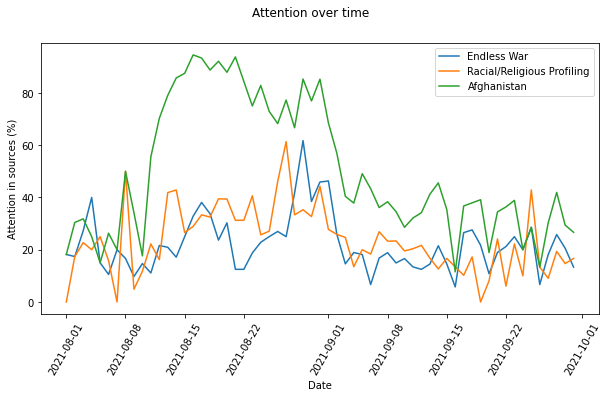

Time to run: 9.7 s


In [70]:
# testing attention_plots function
# defining queries
# queries = ['"9/11"', '"afghanistan"']
# queries = '"9/11" OR "afghanistan"'
# queries = [sep11_search, endless_war_search, profiling_search, "afghanistan"]
queries = [endless_war_search, profiling_search, "afghanistan"]
query_labels = ["Endless War", "Racial/Religious Profiling", "Afghanistan"]

# defining date range
date_range = ["8/1/2021", "9/30/2021"]

# running and timing function
import time
start_time = time.time()
test_fig = attention_plots(queries, novetta_sources, date_range, 
                           query_labels=query_labels, query_context=sep11_search, verbose=False)
end_time = time.time()
print(f"Time to run: {round(end_time-start_time, 2)} s")

In [9]:
# Save the test_fig from the cell above as an image. Adjust the img_path and img_name variables as necessary.
img_path = "/home/lana-e/Code/rethink/rethink_mediacloud/notebooks/"
img_name = "attention_within_sep11_stories"
test_fig.savefig(img_path + img_name, bbox_inches="tight", facecolor="w")

## Using a MediaCloud collection as the source
This section explores the process to use a MediaCloud collection of sources (specifically "United States - National") as the source input for the functions. The collection has 271 sources in total.

In [71]:
us_collection = {"US National Collection": 34412234}
last_month = ["11/01/2021", "11/30/2021"]
page_dates = ["11/21/2020", "12/07/2020"]
jenn_dates = ["04/15/2015", "05/01/2015"]

In [72]:
search_sources(query='"elliot page" OR "ellen page"', sources={"US National Collection": 34412234},
               source_type="collection", date_range=page_dates, query_context="transgender OR trans")

Query: "elliot page" OR "ellen page"


,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
34412234,US National Collection,162,1205,13.443983


In [73]:
search_sources(query='"bruce jenner" OR "caitlin jenner"', sources={"US National Collection": 34412234},
               source_type="collection", date_range=jenn_dates, query_context="transgender OR trans")

Query: "bruce jenner" OR "caitlin jenner"


,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
34412234,US National Collection,331,1562,21.190781
